### ResNet50 + MNIST & CIFAR-10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import pandas as pd

In [2]:
# Random seed 고정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [3]:
# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]) # MNIST, (1, 28, 28)

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # CIFAR-10, (3, 32, 32)

# MNIST
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train/Validation split
train_size = int(0.8 * len(train_dataset_mnist))
validation_size = len(train_dataset_mnist) - train_size
train_dataset_mnist, val_dataset_mnist = random_split(train_dataset_mnist, [train_size, validation_size])

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(dataset=val_dataset_mnist, batch_size=64, shuffle=False)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=64, shuffle=False)

# CIFAR-10
train_dataset_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# Train/Validation split
train_size = int(0.8 * len(train_dataset_cifar10))
validation_size = len(train_dataset_cifar10) - train_size
train_dataset_cifar10, val_dataset_cifar10 = random_split(train_dataset_cifar10, [train_size, validation_size])

train_loader_cifar10 = DataLoader(dataset=train_dataset_cifar10, batch_size=64, shuffle=True)
val_loader_cifar10 = DataLoader(dataset=val_dataset_cifar10, batch_size=64, shuffle=False)
test_loader_cifar10 = DataLoader(dataset=test_dataset_cifar10, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12820767.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 347981.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3214310.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5919990.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:05<00:00, 29534551.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self, dataset_name, activation_func):
        super(ResNet50, self).__init__()
        self.dataset_name = dataset_name
        if dataset_name == 'MNIST':
            self.num_classes = 10
            self.resnet = resnet50(pretrained=False)
            self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.resnet.bn1 = nn.BatchNorm2d(64)  # Batch Normalization 추가
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.num_classes)
        elif dataset_name == 'CIFAR10':
            self.num_classes = 10
            self.resnet = resnet50(pretrained=False)
            self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.resnet.bn1 = nn.BatchNorm2d(64)  # Batch Normalization 추가
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.num_classes)
        else:
            raise ValueError("지원되지 않는 데이터셋 이름")

        self.activation_func = activation_func

        # 레이어를 GPU로 이동
        self.to('cuda')  # 또는 self.to(torch.device("cuda"))

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)  # Batch Normalization 추가
        x = self.activation_func(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x

In [5]:
dataset_name = 'MNIST'
resnet_model = ResNet50(dataset_name, F.relu)
for name, p in resnet_model.named_parameters():
	print(name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


resnet.conv1.weight
resnet.bn1.weight
resnet.bn1.bias
resnet.layer1.0.conv1.weight
resnet.layer1.0.bn1.weight
resnet.layer1.0.bn1.bias
resnet.layer1.0.conv2.weight
resnet.layer1.0.bn2.weight
resnet.layer1.0.bn2.bias
resnet.layer1.0.conv3.weight
resnet.layer1.0.bn3.weight
resnet.layer1.0.bn3.bias
resnet.layer1.0.downsample.0.weight
resnet.layer1.0.downsample.1.weight
resnet.layer1.0.downsample.1.bias
resnet.layer1.1.conv1.weight
resnet.layer1.1.bn1.weight
resnet.layer1.1.bn1.bias
resnet.layer1.1.conv2.weight
resnet.layer1.1.bn2.weight
resnet.layer1.1.bn2.bias
resnet.layer1.1.conv3.weight
resnet.layer1.1.bn3.weight
resnet.layer1.1.bn3.bias
resnet.layer1.2.conv1.weight
resnet.layer1.2.bn1.weight
resnet.layer1.2.bn1.bias
resnet.layer1.2.conv2.weight
resnet.layer1.2.bn2.weight
resnet.layer1.2.bn2.bias
resnet.layer1.2.conv3.weight
resnet.layer1.2.bn3.weight
resnet.layer1.2.bn3.bias
resnet.layer2.0.conv1.weight
resnet.layer2.0.bn1.weight
resnet.layer2.0.bn1.bias
resnet.layer2.0.conv2.weight
r

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [7]:
def train_and_evaluate_model(activation_function, train_loader, val_loader, test_loader, epochs=50, patience=5):
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet50(dataset_name, activation_function).to(device)
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    f1_scores = []
    epoch_times = []
    gradients = {name: [] for name, param in model.named_parameters() if param.requires_grad and 'weight' in name}
    # requires_grad==True이면 Gradient 계산 대상, bias 제외한 weight만 모으기 위해 조건 추가

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        start_time = time.time() # epoch마다 학습 시간 (시작)
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        ############################################################
        # Collect gradients at the end of the epoch
        for name, param in model.named_parameters():
            if param.requires_grad and 'weight' in name:
                gradients[name].append(torch.norm(param.grad, p=2).item())
        ############################################################

        train_loss_history.append(train_loss / len(train_loader))
        train_acc_history.append(100. * correct / total)
        epoch_time = time.time() - start_time # 학습 시간 (종료)
        epoch_times.append(epoch_time)

        # Evaluation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(100. * correct / total)
        f1_scores.append(f1_score(all_targets, all_predictions, average='macro'))

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss_history[-1]:.3f}, Val Loss: {val_loss_history[-1]:.3f}, Train Acc: {train_acc_history[-1]:.2f}%, Val Acc: {val_acc_history[-1]:.2f}%, F1 Score: {f1_scores[-1]:.3f}, Time: {epoch_time:.2f}s')

        # Early stopping check
        if val_loss_history[-1] < best_val_loss:
            best_val_loss = val_loss_history[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Final evaluation on test set
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    test_f1 = f1_score(all_targets, all_predictions, average='macro')

    print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%, Test F1 Score: {test_f1:.3f}')


    results_df = pd.DataFrame({
        'epoch': list(range(1, len(train_loss_history) + 1)),
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'f1_scores': f1_scores,
        'epoch_times': epoch_times,
    })

    gradients_df = pd.DataFrame(gradients)

    return results_df, gradients_df, {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_f1': test_f1
    }

In [8]:
activation_functions = {
    'sigmoid': torch.sigmoid,
    'ReLU': F.relu,
    'LReLU': F.leaky_relu,
    'ELU': F.elu,
    'SeLU': F.selu
}

results_mnist = {}
results_cifar10 = {}

for name, activation in activation_functions.items():
    print(f'Running experiment with {name} activation on MNIST')
    dataset_name = 'MNIST'
    results_mnist[name] = train_and_evaluate_model(activation, train_loader_mnist, val_loader_mnist, test_loader_mnist)

    print(f'Running experiment with {name} activation on CIFAR-10')
    dataset_name = 'CIFAR10'
    results_cifar10[name] = train_and_evaluate_model(activation, train_loader_cifar10, val_loader_cifar10, test_loader_cifar10)

Running experiment with sigmoid activation on MNIST


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1, Train Loss: 0.347, Val Loss: 0.225, Train Acc: 90.58%, Val Acc: 93.53%, F1 Score: 0.935, Time: 46.79s
Epoch: 2, Train Loss: 0.204, Val Loss: 0.096, Train Acc: 94.97%, Val Acc: 97.03%, F1 Score: 0.970, Time: 45.70s
Epoch: 3, Train Loss: 0.129, Val Loss: 0.349, Train Acc: 96.59%, Val Acc: 89.74%, F1 Score: 0.897, Time: 45.67s
Epoch: 4, Train Loss: 0.129, Val Loss: 0.074, Train Acc: 96.75%, Val Acc: 97.66%, F1 Score: 0.976, Time: 45.74s
Epoch: 5, Train Loss: 0.064, Val Loss: 0.183, Train Acc: 98.14%, Val Acc: 94.99%, F1 Score: 0.949, Time: 45.85s
Epoch: 6, Train Loss: 0.078, Val Loss: 0.054, Train Acc: 97.93%, Val Acc: 98.36%, F1 Score: 0.984, Time: 45.64s
Epoch: 7, Train Loss: 0.043, Val Loss: 0.053, Train Acc: 98.77%, Val Acc: 98.41%, F1 Score: 0.984, Time: 45.62s
Epoch: 8, Train Loss: 0.038, Val Loss: 0.074, Train Acc: 98.85%, Val Acc: 98.02%, F1 Score: 0.980, Time: 45.65s
Epoch: 9, Train Loss: 0.043, Val Loss: 0.073, Train Acc: 98.79%, Val Acc: 97.88%, F1 Score: 0.979, Time:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 1.831, Test Acc: 50.73%, Test F1 Score: 0.487
Running experiment with sigmoid activation on CIFAR-10
Epoch: 1, Train Loss: 1.789, Val Loss: 3.140, Train Acc: 43.10%, Val Acc: 46.63%, F1 Score: 0.462, Time: 58.93s
Epoch: 2, Train Loss: 1.214, Val Loss: 1.074, Train Acc: 58.15%, Val Acc: 62.45%, F1 Score: 0.620, Time: 58.96s
Epoch: 3, Train Loss: 1.045, Val Loss: 0.979, Train Acc: 63.95%, Val Acc: 66.28%, F1 Score: 0.660, Time: 58.92s
Epoch: 4, Train Loss: 0.957, Val Loss: 0.884, Train Acc: 67.38%, Val Acc: 69.37%, F1 Score: 0.693, Time: 58.81s
Epoch: 5, Train Loss: 0.722, Val Loss: 0.825, Train Acc: 74.90%, Val Acc: 71.84%, F1 Score: 0.719, Time: 58.95s
Epoch: 6, Train Loss: 0.660, Val Loss: 0.753, Train Acc: 77.64%, Val Acc: 73.96%, F1 Score: 0.741, Time: 58.94s
Epoch: 7, Train Loss: 0.650, Val Loss: 0.668, Train Acc: 78.66%, Val Acc: 77.50%, F1 Score: 0.774, Time: 58.97s
Epoch: 8, Train Loss: 0.617, Val Loss: 1.520, Train Acc: 79.67%, Val Acc: 67.01%, F1 Score: 0.668, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 0.332, Val Loss: 0.189, Train Acc: 90.96%, Val Acc: 94.10%, F1 Score: 0.940, Time: 45.73s
Epoch: 2, Train Loss: 0.190, Val Loss: 0.085, Train Acc: 95.39%, Val Acc: 97.52%, F1 Score: 0.975, Time: 45.69s
Epoch: 3, Train Loss: 0.071, Val Loss: 0.063, Train Acc: 98.03%, Val Acc: 98.29%, F1 Score: 0.983, Time: 45.82s
Epoch: 4, Train Loss: 0.111, Val Loss: 0.075, Train Acc: 97.12%, Val Acc: 97.83%, F1 Score: 0.978, Time: 45.75s
Epoch: 5, Train Loss: 0.082, Val Loss: 0.047, Train Acc: 97.86%, Val Acc: 98.65%, F1 Score: 0.986, Time: 45.79s
Epoch: 6, Train Loss: 0.040, Val Loss: 0.067, Train Acc: 98.82%, Val Acc: 98.12%, F1 Score: 0.981, Time: 45.72s
Epoch: 7, Train Loss: 0.037, Val Loss: 0.050, Train Acc: 98.87%, Val Acc: 98.67%, F1 Score: 0.987, Time: 45.68s
Epoch: 8, Train Loss: 0.037, Val Loss: 0.090, Train Acc: 98.90%, Val Acc: 98.08%, F1 Score: 0.981, Time: 45.66s
Epoch: 9, Train Loss: 0.035, Val Loss: 0.058, Train Acc: 98.96%, Val Acc: 98.53%, F1 Score: 0.985, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 1.747, Val Loss: 1.500, Train Acc: 44.81%, Val Acc: 54.11%, F1 Score: 0.534, Time: 58.86s
Epoch: 2, Train Loss: 1.249, Val Loss: 1.144, Train Acc: 57.44%, Val Acc: 59.96%, F1 Score: 0.596, Time: 58.94s
Epoch: 3, Train Loss: 1.033, Val Loss: 1.025, Train Acc: 64.19%, Val Acc: 65.24%, F1 Score: 0.652, Time: 59.04s
Epoch: 4, Train Loss: 0.875, Val Loss: 0.767, Train Acc: 69.86%, Val Acc: 72.67%, F1 Score: 0.727, Time: 58.95s
Epoch: 5, Train Loss: 0.688, Val Loss: 0.751, Train Acc: 76.11%, Val Acc: 74.13%, F1 Score: 0.737, Time: 58.98s
Epoch: 6, Train Loss: 0.995, Val Loss: 0.770, Train Acc: 67.00%, Val Acc: 73.45%, F1 Score: 0.737, Time: 59.00s
Epoch: 7, Train Loss: 0.712, Val Loss: 0.689, Train Acc: 75.97%, Val Acc: 75.84%, F1 Score: 0.757, Time: 59.04s
Epoch: 8, Train Loss: 0.625, Val Loss: 0.665, Train Acc: 78.74%, Val Acc: 76.74%, F1 Score: 0.766, Time: 58.93s
Epoch: 9, Train Loss: 0.648, Val Loss: 1.145, Train Acc: 78.04%, Val Acc: 59.61%, F1 Score: 0.590, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 0.344, Val Loss: 0.112, Train Acc: 90.88%, Val Acc: 96.49%, F1 Score: 0.965, Time: 45.78s
Epoch: 2, Train Loss: 0.180, Val Loss: 0.149, Train Acc: 95.84%, Val Acc: 95.45%, F1 Score: 0.954, Time: 45.71s
Epoch: 3, Train Loss: 0.173, Val Loss: 1.433, Train Acc: 95.66%, Val Acc: 76.38%, F1 Score: 0.763, Time: 45.69s
Epoch: 4, Train Loss: 0.125, Val Loss: 0.067, Train Acc: 96.67%, Val Acc: 97.99%, F1 Score: 0.980, Time: 45.68s
Epoch: 5, Train Loss: 0.071, Val Loss: 0.054, Train Acc: 98.10%, Val Acc: 98.35%, F1 Score: 0.983, Time: 45.75s
Epoch: 6, Train Loss: 0.064, Val Loss: 0.077, Train Acc: 98.37%, Val Acc: 97.57%, F1 Score: 0.975, Time: 45.70s
Epoch: 7, Train Loss: 0.085, Val Loss: 0.059, Train Acc: 98.14%, Val Acc: 98.39%, F1 Score: 0.984, Time: 45.70s
Epoch: 8, Train Loss: 0.103, Val Loss: 0.061, Train Acc: 97.52%, Val Acc: 98.25%, F1 Score: 0.982, Time: 45.68s
Epoch: 9, Train Loss: 0.058, Val Loss: 0.047, Train Acc: 98.30%, Val Acc: 98.61%, F1 Score: 0.986, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 1.791, Val Loss: 1.666, Train Acc: 42.48%, Val Acc: 48.77%, F1 Score: 0.477, Time: 58.90s
Epoch: 2, Train Loss: 1.191, Val Loss: 1.352, Train Acc: 58.36%, Val Acc: 58.03%, F1 Score: 0.576, Time: 59.11s
Epoch: 3, Train Loss: 0.973, Val Loss: 0.902, Train Acc: 66.51%, Val Acc: 68.39%, F1 Score: 0.683, Time: 58.92s
Epoch: 4, Train Loss: 0.832, Val Loss: 0.854, Train Acc: 71.21%, Val Acc: 70.14%, F1 Score: 0.699, Time: 58.97s
Epoch: 5, Train Loss: 0.793, Val Loss: 3.149, Train Acc: 73.23%, Val Acc: 48.26%, F1 Score: 0.473, Time: 58.96s
Epoch: 6, Train Loss: 0.723, Val Loss: 0.688, Train Acc: 75.17%, Val Acc: 76.40%, F1 Score: 0.767, Time: 58.99s
Epoch: 7, Train Loss: 0.602, Val Loss: 0.635, Train Acc: 79.28%, Val Acc: 78.25%, F1 Score: 0.783, Time: 58.96s
Epoch: 8, Train Loss: 0.428, Val Loss: 0.650, Train Acc: 85.06%, Val Acc: 78.25%, F1 Score: 0.784, Time: 58.92s
Epoch: 9, Train Loss: 0.504, Val Loss: 0.660, Train Acc: 82.94%, Val Acc: 78.08%, F1 Score: 0.782, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 0.372, Val Loss: 0.158, Train Acc: 90.41%, Val Acc: 95.17%, F1 Score: 0.951, Time: 45.66s
Epoch: 2, Train Loss: 0.134, Val Loss: 0.182, Train Acc: 96.55%, Val Acc: 95.62%, F1 Score: 0.956, Time: 45.71s
Epoch: 3, Train Loss: 0.125, Val Loss: 0.066, Train Acc: 96.74%, Val Acc: 98.09%, F1 Score: 0.981, Time: 45.69s
Epoch: 4, Train Loss: 0.127, Val Loss: 0.095, Train Acc: 96.94%, Val Acc: 97.15%, F1 Score: 0.971, Time: 45.66s
Epoch: 5, Train Loss: 0.074, Val Loss: 0.065, Train Acc: 98.19%, Val Acc: 98.13%, F1 Score: 0.981, Time: 45.68s
Epoch: 6, Train Loss: 0.224, Val Loss: 0.112, Train Acc: 94.45%, Val Acc: 96.63%, F1 Score: 0.966, Time: 45.77s
Epoch: 7, Train Loss: 0.111, Val Loss: 0.087, Train Acc: 97.11%, Val Acc: 97.39%, F1 Score: 0.973, Time: 45.72s
Epoch: 8, Train Loss: 0.081, Val Loss: 0.060, Train Acc: 97.71%, Val Acc: 98.24%, F1 Score: 0.982, Time: 45.74s
Epoch: 9, Train Loss: 0.054, Val Loss: 0.054, Train Acc: 98.56%, Val Acc: 98.29%, F1 Score: 0.983, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 1.815, Val Loss: 2.012, Train Acc: 41.92%, Val Acc: 48.68%, F1 Score: 0.484, Time: 58.92s
Epoch: 2, Train Loss: 1.225, Val Loss: 1.146, Train Acc: 57.44%, Val Acc: 63.31%, F1 Score: 0.627, Time: 58.99s
Epoch: 3, Train Loss: 1.052, Val Loss: 1.034, Train Acc: 63.36%, Val Acc: 65.55%, F1 Score: 0.654, Time: 59.02s
Epoch: 4, Train Loss: 0.913, Val Loss: 0.841, Train Acc: 68.38%, Val Acc: 70.61%, F1 Score: 0.702, Time: 58.88s
Epoch: 5, Train Loss: 0.844, Val Loss: 0.836, Train Acc: 71.41%, Val Acc: 70.71%, F1 Score: 0.702, Time: 58.96s
Epoch: 6, Train Loss: 0.897, Val Loss: 0.732, Train Acc: 70.52%, Val Acc: 74.97%, F1 Score: 0.751, Time: 58.91s
Epoch: 7, Train Loss: 0.657, Val Loss: 0.820, Train Acc: 77.64%, Val Acc: 73.11%, F1 Score: 0.730, Time: 58.88s
Epoch: 8, Train Loss: 0.835, Val Loss: 0.774, Train Acc: 71.81%, Val Acc: 72.97%, F1 Score: 0.730, Time: 58.82s
Epoch: 9, Train Loss: 0.527, Val Loss: 0.671, Train Acc: 81.51%, Val Acc: 76.89%, F1 Score: 0.769, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 0.361, Val Loss: 0.153, Train Acc: 90.46%, Val Acc: 95.21%, F1 Score: 0.952, Time: 45.70s
Epoch: 2, Train Loss: 0.175, Val Loss: 0.151, Train Acc: 95.50%, Val Acc: 95.25%, F1 Score: 0.952, Time: 45.70s
Epoch: 3, Train Loss: 0.092, Val Loss: 0.068, Train Acc: 97.08%, Val Acc: 97.91%, F1 Score: 0.979, Time: 45.68s
Epoch: 4, Train Loss: 0.054, Val Loss: 0.065, Train Acc: 98.31%, Val Acc: 98.01%, F1 Score: 0.980, Time: 45.73s
Epoch: 5, Train Loss: 0.133, Val Loss: 0.086, Train Acc: 96.73%, Val Acc: 97.56%, F1 Score: 0.975, Time: 45.66s
Epoch: 6, Train Loss: 0.071, Val Loss: 0.075, Train Acc: 98.02%, Val Acc: 97.67%, F1 Score: 0.976, Time: 45.73s
Epoch: 7, Train Loss: 0.134, Val Loss: 0.067, Train Acc: 96.92%, Val Acc: 98.04%, F1 Score: 0.980, Time: 45.74s
Epoch: 8, Train Loss: 0.125, Val Loss: 0.066, Train Acc: 96.87%, Val Acc: 98.03%, F1 Score: 0.980, Time: 45.67s
Epoch: 9, Train Loss: 0.068, Val Loss: 0.053, Train Acc: 98.04%, Val Acc: 98.33%, F1 Score: 0.983, Time:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 1, Train Loss: 1.784, Val Loss: 2.545, Train Acc: 41.48%, Val Acc: 52.26%, F1 Score: 0.515, Time: 59.00s
Epoch: 2, Train Loss: 1.181, Val Loss: 1.541, Train Acc: 58.67%, Val Acc: 61.59%, F1 Score: 0.613, Time: 58.99s
Epoch: 3, Train Loss: 0.982, Val Loss: 0.910, Train Acc: 66.03%, Val Acc: 68.28%, F1 Score: 0.682, Time: 59.01s
Epoch: 4, Train Loss: 0.989, Val Loss: 0.850, Train Acc: 66.04%, Val Acc: 69.83%, F1 Score: 0.696, Time: 58.98s
Epoch: 5, Train Loss: 0.837, Val Loss: 1.237, Train Acc: 71.40%, Val Acc: 71.83%, F1 Score: 0.716, Time: 58.99s
Epoch: 6, Train Loss: 0.648, Val Loss: 0.941, Train Acc: 77.43%, Val Acc: 71.03%, F1 Score: 0.712, Time: 59.07s
Epoch: 7, Train Loss: 0.528, Val Loss: 0.687, Train Acc: 81.67%, Val Acc: 76.60%, F1 Score: 0.764, Time: 59.05s
Epoch: 8, Train Loss: 0.438, Val Loss: 0.846, Train Acc: 84.76%, Val Acc: 75.09%, F1 Score: 0.754, Time: 58.92s
Epoch: 9, Train Loss: 0.696, Val Loss: 0.789, Train Acc: 78.20%, Val Acc: 72.86%, F1 Score: 0.730, Time:

In [9]:
dataset_name = 'MNIST'
resnet_model_mnist = ResNet50(dataset_name, F.relu)
print(resnet_model_mnist)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [10]:
dataset_name = 'CIFAR10'
resnet_model_cifar10 = ResNet50(dataset_name, F.relu)
print(resnet_model_cifar10)

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### Dataframe 저장

In [20]:
for name, result in results_mnist.items():
  results_df = result[0]
  gradients_df = result[1]
  results_df.to_csv(f'{name}-result-mnist.csv')
  gradients_df.to_csv(f'{name}-grad-mnist.csv')

In [21]:
for name, result in results_cifar10.items():
  results_df = result[0]
  gradients_df = result[1]
  results_df.to_csv(f'{name}-result-cifar10.csv')
  gradients_df.to_csv(f'{name}-grad-cifar10.csv')

In [22]:
# Test 결과 저장
def save_test_results_to_dataframe(results, filename):
    data = {
        'Activation Function': [],
        'Test Accuracy': [],
        'Test Loss': [],
        'Test F1 Score': []
    }

    for activation_name, result in results.items():
        data['Activation Function'].append(activation_name)
        data['Test Accuracy'].append(result[2]['test_acc'])
        data['Test Loss'].append(result[2]['test_loss'])
        data['Test F1 Score'].append(result[2]['test_f1'])

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

save_test_results_to_dataframe(results_mnist, 'test-mnist.csv')
save_test_results_to_dataframe(results_cifar10, 'test-cifar10.csv')

### Loss, Acc, F1-score 시각화 (그래프)

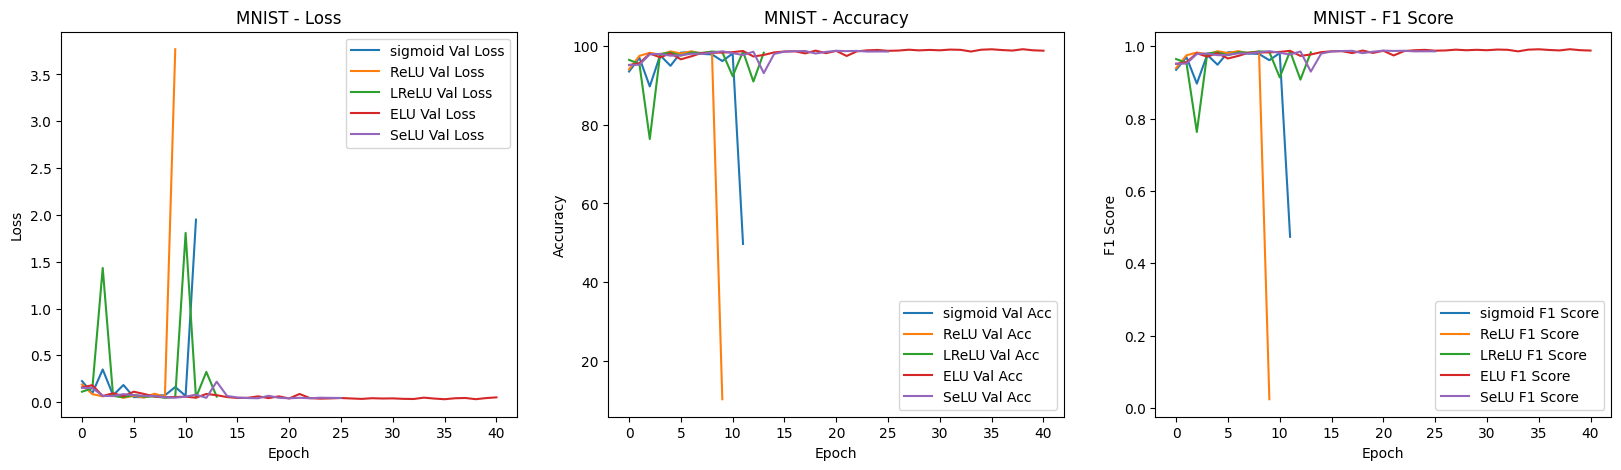

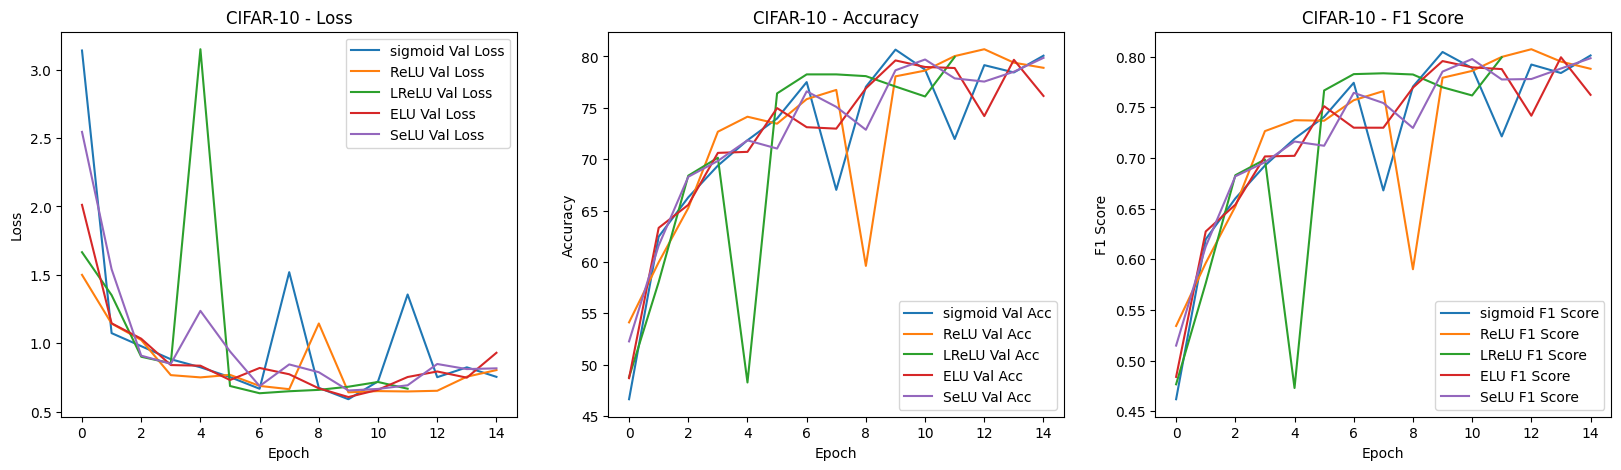

In [23]:
# loss, acc, f1 score
def plot_results_1(results, title):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    for name, result in results.items():
        plt.plot(result[0]['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    for name, result in results.items():
        plt.plot(result[0]['val_acc'], label=f'{name} Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    for name, result in results.items():
        plt.plot(result[0]['f1_scores'], label=f'{name} F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{title} - F1 Score')
    plt.legend()

    plt.show()

plot_results_1(results_mnist, 'MNIST')
plot_results_1(results_cifar10, 'CIFAR-10')

### Gradient 시각화
  - 층마다 평균 가중치 시각화

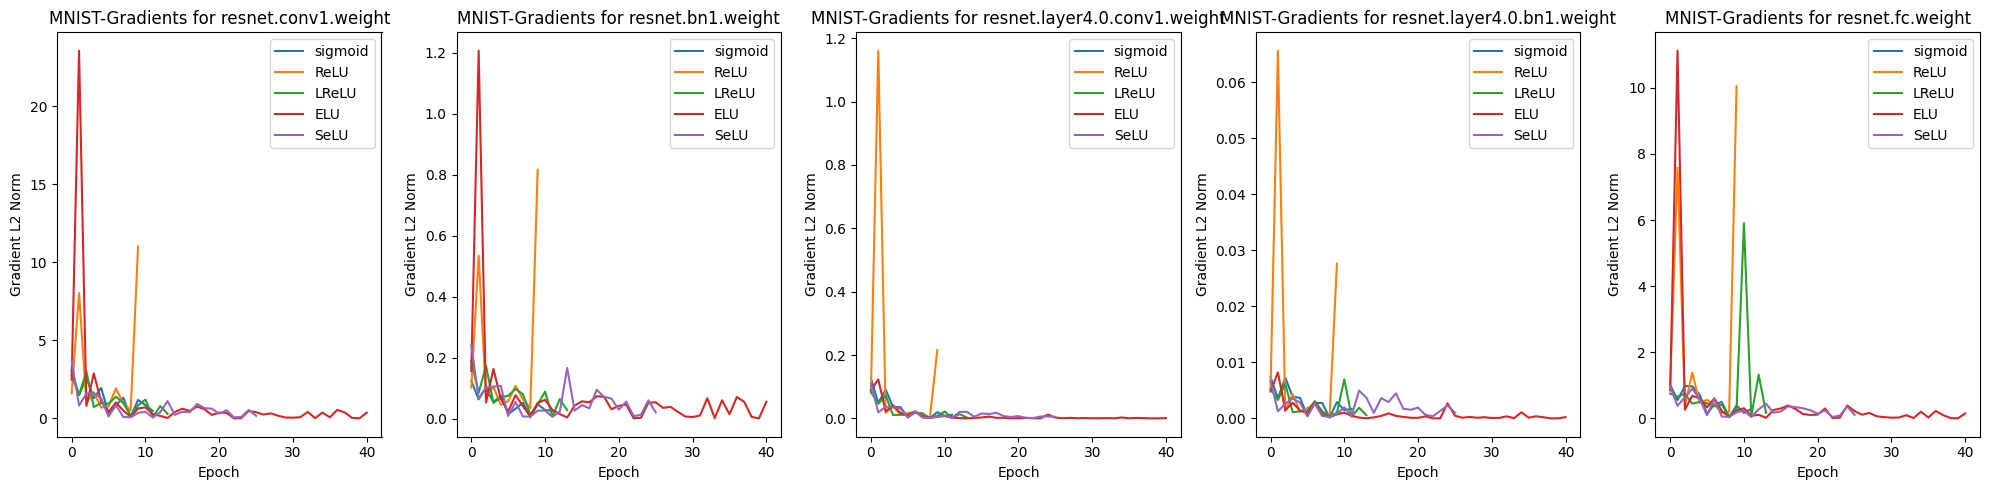

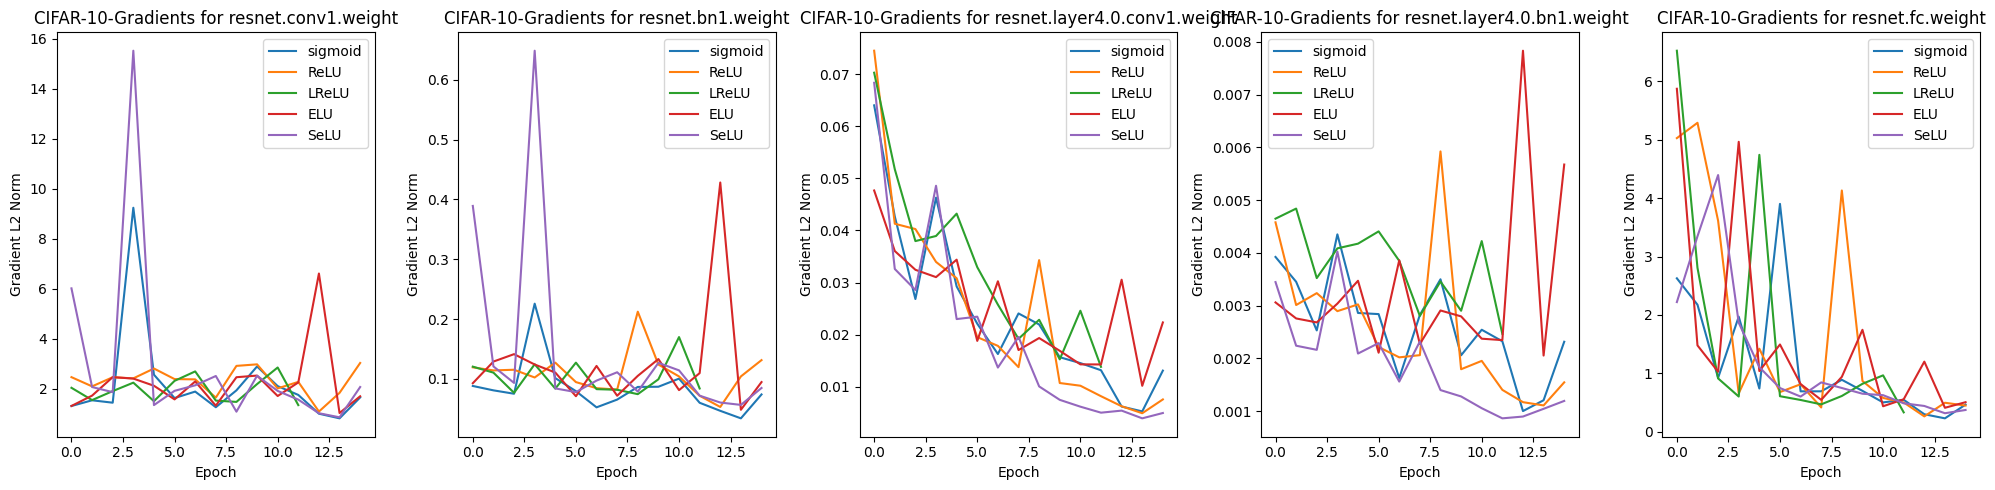

In [24]:
def plot_gradients(results, title):
    # 레이어와 활성화 함수 이름
    layers = ["resnet.conv1.weight", "resnet.bn1.weight", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.bn1.weight", "resnet.fc.weight"]
    activation_functions = list(results.keys())

    # 시각화
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))

    for i, layer in enumerate(layers):
        for activation in activation_functions:
            axs[i].plot(results[activation][1][layer], label=activation)
        axs[i].set_title(f'{title}-Gradients for {layer}')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Gradient L2 Norm')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_gradients(results_mnist, 'MNIST')
plot_gradients(results_cifar10, 'CIFAR-10')

### 학습 시간
  - 전체 시간, Epoch 평균

In [25]:
def pd_time(results):
    results_list = {'sigmoid': [],
                    'ReLU': [],
                    'LReLU': [],
                    'ELU': [],
                    'SeLU': []}
    for name, result in results.items():
        epoch = len(result[0]['epoch_times'])
        all = sum(result[0]['epoch_times'])
        avg = all / epoch
        results_list[name] = [all, avg]

    return pd.DataFrame(results_list, index = ['전체 시간', '평균 시간'])

In [26]:
time_mnist = pd_time(results_mnist)
time_mnist.to_csv('time-mnist.csv')
time_cifar10 = pd_time(results_cifar10)
time_cifar10.to_csv('time-cifar10.csv')
print("MNIST Training Times:")
print(time_mnist)
print("\nCIFAR-10 Training Times:")
print(time_cifar10)

MNIST Training Times:
          sigmoid        ReLU       LReLU          ELU         SeLU
전체 시간  549.269837  457.417414  639.980870  1874.073853  1188.108201
평균 시간   45.772486   45.741741   45.712919    45.709118    45.696469

CIFAR-10 Training Times:
          sigmoid        ReLU       LReLU         ELU        SeLU
전체 시간  883.641253  883.913261  707.658910  883.448726  884.382028
평균 시간   58.909417   58.927551   58.971576   58.896582   58.958802


### Test 결과

In [27]:
mnist_test_results_df = pd.read_csv('test-mnist.csv')
cifar10_test_results_df = pd.read_csv('test-cifar10.csv')

print("MNIST Test Results:")
print(mnist_test_results_df)

print("\nCIFAR-10 Test Results:")
print(cifar10_test_results_df)

MNIST Test Results:
  Activation Function  Test Accuracy  Test Loss  Test F1 Score
0             sigmoid          50.73   1.831071       0.486719
1                ReLU          10.60   3.775830       0.024371
2               LReLU          98.45   0.049586       0.984450
3                 ELU          99.04   0.039379       0.990273
4                SeLU          98.68   0.042202       0.986765

CIFAR-10 Test Results:
  Activation Function  Test Accuracy  Test Loss  Test F1 Score
0             sigmoid          78.75   0.796735       0.787996
1                ReLU          78.07   0.832961       0.779714
2               LReLU          79.00   0.709554       0.789329
3                 ELU          76.20   0.971509       0.762722
4                SeLU          78.68   0.878769       0.786397
